## Import libraries

In [1]:
# !pip install tensorly

import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from tensorly.decomposition import tensor_train
from math import ceil
from tensorly import tt_to_tensor
from tensorly.decomposition import matrix_product_state
import torch.nn.init as init

In [2]:
"""
5 runs of 50 epochs, seed = 10, 20, 30, 40, 50;
validation accuracies: 0.9492, 0.9457, 0.9463, 0.9439, 0.9455
"""
#from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

dtype = torch.float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version: 1.13.1
Torchvision Version: 0.14.1
GPU is available? True


## train data processing

In [3]:
df_train_1 = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_training.csv')
df_train_2 = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_validation.csv')
# concat train and validation into train. we don't need validation set
df_train = df_train_1.append(df_train_2).reset_index(drop=True)

# undersampling for "negative" samples
negative_df = df_train[df_train['label'] == 'Negative']
positive_df = df_train[df_train['label'] == 'Positive']

# Get number of "positive" samples
num_positive = len(positive_df)

# take the same number of "negative" samples as there are "positive" samples
balanced_negative_df = negative_df.sample(n=num_positive, random_state=10086)

df_train_balanced = pd.concat([positive_df, balanced_negative_df])
print(df_train_balanced['label'].value_counts())

Positive    4057
Negative    4057
Name: label, dtype: int64


In [4]:
pd_X_train = df_train_balanced.iloc[:, 5:]
pd_y_train = df_train_balanced.iloc[:, 0]

N = len(pd_X_train)
K = 2

pd_X_train = pd_X_train.values
X_train = torch.tensor(pd_X_train, dtype=dtype, device=device)
X_train = torch.t(X_train)

# scaler = MinMaxScaler()
# x = pd_X_train.values
# x_scaled = scaler.fit_transform(x)
# X_train = torch.tensor(x_scaled, dtype=dtype, device=device)
# X_train = torch.t(X_train)

# Initialize the LabelEncoder
encoder = LabelEncoder()
# Fit and transform the y values
y = encoder.fit_transform(pd_y_train.values)
y_train=torch.tensor(y, dtype=torch.long, device=device)
y_train = torch.flatten(y_train)

y_one_hot = torch.zeros(N, K, device=device).scatter_(1, y_train.unsqueeze(1), 1)
y_one_hot = torch.t(y_one_hot).to(device=device)

print(list(encoder.classes_))

['Negative', 'Positive']


## test data processing

In [5]:
df_test = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_testing.csv')

# Undersampling for "negative" samples
#negative_df = df_test[df_test['label'] == 'Negative']
#positive_df = df_test[df_test['label'] == 'Positive']

# Get number of "positive" samples
#num_positive = len(positive_df)

# Take the same number of "negative" samples as there are "positive" samples
#balanced_negative_df = negative_df.sample(n=num_positive, random_state=10086)

#df_test_balanced = pd.concat([positive_df, balanced_negative_df])
#print(df_test_balanced['label'].value_counts())

In [6]:
pd_X_test = df_test.iloc[:, 5:]
pd_y_test = df_test.iloc[:, 0]

N_test = len(pd_X_test)
K = 2

pd_X_test = pd_X_test.values
X_test = torch.tensor(pd_X_test, dtype=dtype, device=device)
X_test = torch.t(X_test)
# x = pd_X_test.values
# x_scaled = scaler.transform(x)  # only transform x, don't fit the scaler again
# X_test = torch.tensor(x_scaled, dtype=dtype, device=device)
# X_test = torch.t(X_test)


# Initialize the LabelEncoder
encoder = LabelEncoder()
# Fit and transform the y values
y = encoder.fit_transform(pd_y_test.values)
y_test=torch.tensor(y, dtype=torch.long, device=device)
y_test = torch.flatten(y_test)

y_test_one_hot = torch.zeros(N_test, K, device=device).scatter_(1, y_test.unsqueeze(1), 1)
y_test_one_hot = torch.t(y_test_one_hot).to(device=device)

In [7]:
print(df_test['label'].value_counts())

Negative    43411
Positive     1278
Name: label, dtype: int64


## Main algorithm

### Define functions for updating blocks

In [8]:
# def updateMask(W, sparsity):
#     torch.dist(V1,nn.ReLU()(U1),2),2).cpu().numpy()
#     Mask
#     Wsparse
#     return Mask, Wsparse

# Wsquare = torch.square(W3)
# Threshold = torch.quantile(torch.reshape(Wsquare, (-1,)), 0.5, interpolation='linear')
# Wsparse = W3
# Wsparse[Wsquare < Threshold] =  0

# Wsparse

In [9]:
def updateV(U1,U2,W,b,rho,gamma):
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho*(torch.mm(torch.t(W),W))+gamma*I), rho*torch.mm(torch.t(W),U2-b.repeat(1,col_U2))+gamma*U1)
    return Vstar

In [10]:
def updateWb_org(U, V, W, b, alpha, rho):
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse(alpha*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

In [11]:
def updateWb(U, V, W, b, W_tensor_rec, alpha, rho,tau):
    W_tensor_rec = torch.as_tensor(W_tensor_rec,device=device).float()
    W_tensor2matrix = W_tensor_rec.reshape(W.shape)
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+tau*W_tensor2matrix+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse((alpha+tau)*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

In [12]:
def updateWbsparse(U, V, W, b,  W_tensor2matrix, alpha, rho,tau):
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+tau*W_tensor2matrix+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse((alpha+tau)*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

### Define the proximal operator of the ReLU activation function

In [13]:
def relu_prox(a, b, gamma, d, N):
    val = torch.empty(d,N, device=device)
    x = (a+gamma*b)/(1+gamma)
    y = torch.min(b,torch.zeros(d,N, device=device))

    val = torch.where(a+gamma*b < 0, y, torch.zeros(d,N, device=device))
    val = torch.where(((a+gamma*b >= 0) & (b >=0)) | ((a*(gamma-np.sqrt(gamma*(gamma+1))) <= gamma*b) & (b < 0)), x, val)
    val = torch.where((-a <= gamma*b) & (gamma*b <= a*(gamma-np.sqrt(gamma*(gamma+1)))), b, val)
    return val

### Effective Sparsity

In [14]:
def process_weights(W1, W2, W3):
    # Clone the tensors to keep the originals unchanged
    W1, W2, W3 = W1.clone(), W2.clone(), W3.clone()

    while True:
        # Store a copy of the current weights
        old_W1, old_W2, old_W3 = W1.clone(), W2.clone(), W3.clone()

        # Check all rows of W1
        # If all values in a row of W1 are 0, set corresponding column in W2 to 0
        zero_rows_W1 = torch.all(W1 == 0, dim=1)
        W2[:, zero_rows_W1] = 0

        # Check all columns of W2
        # If all values in a column of W2 are 0, set corresponding row in W1 to 0
        zero_cols_W2 = torch.all(W2 == 0, dim=0)
        W1[zero_cols_W2, :] = 0

        # Check all rows of W2
        # If all values in a row of W2 are 0, set corresponding column in W3 to 0
        zero_rows_W2 = torch.all(W2 == 0, dim=1)
        W3[:, zero_rows_W2] = 0

        # Check if matrices are unchanged
        if torch.equal(W1, old_W1) and torch.equal(W2, old_W2) and torch.equal(W3, old_W3):
            break

    return W1, W2, W3

### Parameter initialization

In [15]:
#df = pd.DataFrame()
#df.to_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv')

niter = 1000
sparsity = 0.9

tau = 200
alpha = 1
rho = 1
gamma = 100

        

# Do something with these parameters
print(sparsity, tau, gamma, rho, alpha)

loss1 = np.empty(niter)
loss2 = np.empty(niter)
accuracy_train = np.empty(niter)
accuracy_test = np.empty(niter)
time1 = np.empty(niter)
bacc_train = np.empty(niter)
bacc_test = np.empty(niter)
true_sparsity = np.empty(niter)
effective_sparsity = np.empty(niter)

results = torch.zeros(1, 9, niter)

for Out_iter in range(1):
    rank_initial = 700
    seed = 10 + 10*Out_iter
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)

    d0 = 40
    d1 =  300
    d2 =  100
    d3 = K # Layers: input + 2 hidden + output

    W1 = 0.2*init.xavier_uniform_(torch.empty(d1, d0, device=device,dtype=dtype), gain=1.0)
    b1 = 0*torch.ones(d1, 1, dtype=torch.float64,device=device)
    W1square = torch.square(W1)
    Threshold = torch.quantile(torch.reshape(W1square, (-1,)), sparsity, interpolation='linear')
    W1sparse = W1
    W1sparse[W1square < Threshold] =  0

    W2 = 0.2*init.xavier_uniform_(torch.empty(d2, d1, device=device,dtype=dtype), gain=1.0)
    b2 = 0*torch.ones(d2, 1, dtype=torch.float64,device=device)
    W2square = torch.square(W2)
    Threshold = torch.quantile(torch.reshape(W2square, (-1,)), sparsity, interpolation='linear')
    W2sparse = W2
    W2sparse[W2square < Threshold] =  0


    W3 = 0.2*init.xavier_uniform_(torch.empty(d3, d2, device=device,dtype=dtype), gain=1.0)
    b3 = 0*torch.ones(d3, 1, dtype=torch.float64,device=device)
    # W3square = torch.square(W3)
    # Threshold = torch.quantile(torch.reshape(W3square, (-1,)), sparsity, interpolation='linear')
    # W3sparse = W3
    # W3sparse[W3square < Threshold] =  0


    U1 = torch.addmm(b1.repeat(1, N), W1, X_train)
    V1 = nn.ReLU()(U1)
    U2 = torch.addmm(b2.repeat(1, N), W2, V1)
    V2 = nn.ReLU()(U2)
    U3 = torch.addmm(b3.repeat(1, N), W3, V2)
    V3 = U3
    # U4 = torch.addmm(b4.repeat(1, N), W4, V3)
    # V4 = U4


    print('Train on', N, 'samples, validate on', N_test, 'samples')

    for k in range(niter):

        start = time.time()

        # update V4
        V3 = (y_one_hot + gamma*U3 + alpha*V3)/(1 + gamma + alpha)

        # update U4
        U3 = (gamma*V3 + rho*(torch.mm(W3,V2) + b3.repeat(1,N)))/(gamma + rho)

        # update W4 and b4
        W3, b3 = updateWb_org(U3,V2,W3,b3, alpha,rho)
        # W3square = torch.square(W3)
        # Threshold = torch.quantile(torch.reshape(W3square, (-1,)), sparsity, interpolation='linear')
        # W3sparse = W3
        # W3sparse[W3square < Threshold] =  0
        # update V2
        V2 = updateV(U2,U3,W3,b3,rho,gamma)

        # update U2
        U2 = relu_prox(V2,(rho*torch.addmm(b2.repeat(1,N), W2, V1) + alpha*U2)/(rho + alpha),(rho + alpha)/gamma,d2,N)

        # update W2 and b2

        W2, b2 = updateWbsparse(U2,V1,W2,b2,W2sparse, alpha,rho,tau)
        W2square = torch.square(W2)
        Threshold = torch.quantile(torch.reshape(W2square, (-1,)), sparsity, interpolation='linear')
        W2sparse = W2
        W2sparse[W2square < Threshold] =  0

        # update V1
        V1 = updateV(U1,U2,W2,b2,rho,gamma)

        # update U1
        U1 = relu_prox(V1,(rho*torch.addmm(b1.repeat(1,N), W1, X_train) + alpha*U1)/(rho + alpha),(rho + alpha)/gamma,d1,N)

        # update W1 and b1
        W1, b1 = updateWbsparse(U1,X_train,W1,b1,W1sparse, alpha,rho,tau)
        W1square = torch.square(W1)
        Threshold = torch.quantile(torch.reshape(W1square, (-1,)), sparsity, interpolation='linear')
        W1sparse = W1
        W1sparse[W1square < Threshold] =  0

        a1_train = nn.ReLU()(torch.addmm(b1.repeat(1, N), W1sparse, X_train)).double()
        a2_train = nn.ReLU()(torch.addmm(b2.repeat(1, N),  W2sparse, a1_train)).double()
        pred = torch.argmax(torch.addmm(b3.repeat(1, N), W3, a2_train), dim=0)

        a1_test = nn.ReLU()(torch.addmm(b1.repeat(1, N_test), W1sparse, X_test)).double()
        a2_test = nn.ReLU()(torch.addmm(b2.repeat(1, N_test),  W2sparse, a1_test)).double()
        pred_test = torch.argmax(torch.addmm(b3.repeat(1, N_test), W3, a2_test), dim=0)


        loss1[k] = gamma/2*torch.pow(torch.dist(V3,y_one_hot,2),2).cpu().numpy()
        loss2[k] = loss1[k] + rho/2*torch.pow(torch.dist(torch.addmm(b1.repeat(1,N), W1sparse, X_train),U1,2),2).cpu().numpy() \
        +rho/2*torch.pow(torch.dist(torch.addmm(b2.repeat(1,N),  W2sparse, V1),U2,2),2).cpu().numpy() \
        +rho/2*torch.pow(torch.dist(torch.addmm(b3.repeat(1,N), W3, V2),U3,2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V1,nn.ReLU()(U1),2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V2,nn.ReLU()(U2),2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V3,U3,2),2).cpu().numpy() \
        + tau/2*torch.pow(torch.dist(W1,W1sparse,2),2).cpu().numpy()\
        + tau/2*torch.pow(torch.dist(W2,W2sparse,2),2).cpu().numpy()\
        # + tau/2*torch.pow(torch.dist(W3,W3sparse,2),2).cpu().numpy()

        # compute training accuracy
        correct_train = pred == y_train
        accuracy_train[k] = np.mean(correct_train.cpu().numpy())

        # compute validation accuracy
        correct_test = pred_test == y_test
        accuracy_test[k] = np.mean(correct_test.cpu().numpy())


        pred_train_np = pred.cpu().numpy()
        y_train_np = y_train.cpu().numpy()
        pred_test_np = pred_test.cpu().numpy()
        y_test_np = y_test.cpu().numpy()

        bacc_train[k] = balanced_accuracy_score(y_train_np, pred_train_np)
        bacc_test[k] = balanced_accuracy_score(y_test_np, pred_test_np)

        # compute training time
        stop = time.time()
        duration = stop - start
        time1[k] = duration

        # sparsity
        num_zeros_W1 = torch.sum(W1 == 0).item()
        num_zeros_W2 = torch.sum(W2 == 0).item()
        num_zeros_W3 = torch.sum(W3 == 0).item()
        total_zeros_old = num_zeros_W1 + num_zeros_W2 + num_zeros_W3
        total_weights = d0*d1+d1*d2+d2*d3
        true_sparsity[k] = total_zeros_old / total_weights

        new_W1, new_W2, new_W3 = process_weights(W1, W2, W3)
        num_zeros_W1_new = torch.sum(new_W1 == 0).item()
        num_zeros_W2_new = torch.sum(new_W2 == 0).item()
        num_zeros_W3_new = torch.sum(new_W3 == 0).item()
        total_zeros = num_zeros_W1_new + num_zeros_W2_new + num_zeros_W3_new
        total_weights = d0*d1+d1*d2+d2*d3
        effective_sparsity[k] = total_zeros / total_weights


        # print results
        print('Epoch', k + 1, '/', niter, '\n',
              '-', 'time:', time1[k], '-', 'sq_loss:', loss1[k], '-', 'tot_loss:', loss2[k],
              '-', 'acc:', accuracy_train[k], '-', 'val_acc:', accuracy_test[k],
              '-', 'bacc_train:', bacc_train[k], '-', 'bacc_test:', bacc_test[k],'-', 'true_sparsity:', true_sparsity[k],
             '-', 'effective_sparsity:', effective_sparsity[k])


    results[Out_iter,0,:] = torch.tensor(loss1)
    results[Out_iter,1,:] = torch.tensor(loss2)
    results[Out_iter,2,:] = torch.tensor(accuracy_train)
    results[Out_iter,3,:] = torch.tensor(accuracy_test)
    results[Out_iter,4,:] = torch.tensor(time1)
    results[Out_iter,5,:] = torch.tensor(bacc_train)
    results[Out_iter,6,:] = torch.tensor(bacc_test)
    results[Out_iter,7,:] = torch.tensor(true_sparsity)
    results[Out_iter,8,:] = torch.tensor(effective_sparsity)

#             df=pd.read_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv')
#             new_row = {
#                         'tau': tau, 
#                         'gamma': gamma, 
#                         'rho': rho, 
#                         'alpha': alpha,
#                         'loss1': loss1[niter-1], 
#                         'loss2': loss2[niter-1], 
#                         'accuracy_train': accuracy_train[niter-1],
#                         'accuracy_test': accuracy_test[niter-1], 
#                         'max_accuracy_train': max(accuracy_train),
#                         'max_accuracy_test': max(accuracy_test),
#                         'time': time1[niter-1], 
#                         'BACC_train': bacc_train[niter-1],
#                         'BACC_test': bacc_test[niter-1],
#                         'max_BACC_train': max(bacc_train),
#                         'max_BACC_test': max(bacc_test),
#                         'Sparsity': sparsity,
#                         'seed' : seed
#                     }

#             df=df.append(new_row,ignore_index=True)
#             df.to_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv',index=False)

filename="XavierUniform_" + "niter_"+ str(niter) + "Sparsity_" + str(sparsity) +"tau_" + str(tau) + "gamma_" + str(gamma) + \
                "rho_" + str(rho) + "alpha_" + str(alpha)+ ".mat"
from scipy.io import savemat
%cd /home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/different init/
savemat (filename, {'results': torch.Tensor.numpy(results)})

0.9 200 100 1 1
Train on 8114 samples, validate on 44689 samples
Epoch 1 / 1000 
 - time: 0.6644353866577148 - sq_loss: 396880.9077923053 - tot_loss: 396881.10784341913 - acc: 0.7717525264974119 - val_acc: 0.6976213385844391 - bacc_train: 0.7717525264974119 - bacc_test: 0.80638787562732 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 2 / 1000 
 - time: 0.027137279510498047 - sq_loss: 389212.61835029686 - tot_loss: 389213.3267918453 - acc: 0.8051515898447128 - val_acc: 0.7907538767929468 - bacc_train: 0.8051515898447128 - bacc_test: 0.8493886940593185 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 3 / 1000 
 - time: 0.02693939208984375 - sq_loss: 381737.57546523697 - tot_loss: 381739.0160782444 - acc: 0.8131624352970175 - val_acc: 0.8187025890040055 - bacc_train: 0.8131624352970175 - bacc_test: 0.8599772639352892 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 4 / 1000 
 - time: 0.0

Epoch 28 / 1000 
 - time: 0.0717475414276123 - sq_loss: 235704.7561068736 - tot_loss: 235705.31886868764 - acc: 0.8304165639635198 - val_acc: 0.8475911298082303 - bacc_train: 0.8304165639635199 - bacc_test: 0.8763656410112767 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 29 / 1000 
 - time: 0.06122088432312012 - sq_loss: 231162.9127534717 - tot_loss: 231163.48171574343 - acc: 0.8304165639635198 - val_acc: 0.8477925216496229 - bacc_train: 0.8304165639635199 - bacc_test: 0.8764693013738576 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 30 / 1000 
 - time: 0.06743240356445312 - sq_loss: 226708.1691512784 - tot_loss: 226708.74428525844 - acc: 0.8307862952920877 - val_acc: 0.8479267828772181 - bacc_train: 0.8307862952920877 - bacc_test: 0.8765384082822449 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 31 / 1000 
 - time: 0.061570167541503906 - sq_loss: 222338.89781349202 - tot_loss: 

Epoch 57 / 1000 
 - time: 0.026923418045043945 - sq_loss: 134006.59067523456 - tot_loss: 134007.28504901793 - acc: 0.8331279270396845 - val_acc: 0.854013291861532 - bacc_train: 0.8331279270396845 - bacc_test: 0.8762537883978189 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 58 / 1000 
 - time: 0.026839733123779297 - sq_loss: 131421.27526638133 - tot_loss: 131421.97257119365 - acc: 0.8332511708158737 - val_acc: 0.8540804224753294 - bacc_train: 0.8332511708158739 - bacc_test: 0.8762883418520124 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 59 / 1000 
 - time: 0.026840686798095703 - sq_loss: 128885.79621178974 - tot_loss: 128886.49640547876 - acc: 0.8331279270396845 - val_acc: 0.854326568059254 - bacc_train: 0.8331279270396845 - bacc_test: 0.8764150378507225 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 60 / 1000 
 - time: 0.026914358139038086 - sq_loss: 126399.19562617331 - tot_l

Epoch 89 / 1000 
 - time: 0.026832103729248047 - sq_loss: 71836.71917552529 - tot_loss: 71839.46069542818 - acc: 0.8358392901158491 - val_acc: 0.85942849470787 - bacc_train: 0.8358392901158491 - bacc_test: 0.8771425079261155 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 90 / 1000 
 - time: 0.026894807815551758 - sq_loss: 70450.45303912669 - tot_loss: 70453.57181802978 - acc: 0.8359625338920385 - val_acc: 0.8594956253216676 - bacc_train: 0.8359625338920385 - bacc_test: 0.877177061380309 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 91 / 1000 
 - time: 0.02675771713256836 - sq_loss: 69090.934849829 - tot_loss: 69094.41135773092 - acc: 0.8362090214444171 - val_acc: 0.8594732484504016 - bacc_train: 0.8362090214444171 - bacc_test: 0.8771655435622445 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 92 / 1000 
 - time: 0.026912927627563477 - sq_loss: 67757.64962504369 - tot_loss: 67761.

Epoch 121 / 1000 
 - time: 0.026818037033081055 - sq_loss: 38506.79056575983 - tot_loss: 38509.310821981846 - acc: 0.8364555089967957 - val_acc: 0.8565642551858399 - bacc_train: 0.8364555089967957 - bacc_test: 0.8783262566345065 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 122 / 1000 
 - time: 0.026862144470214844 - sq_loss: 37763.710431241176 - tot_loss: 37766.28729695253 - acc: 0.8363322652206063 - val_acc: 0.8565642551858399 - bacc_train: 0.8363322652206063 - bacc_test: 0.8787059751231713 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 123 / 1000 
 - time: 0.0267794132232666 - sq_loss: 37034.971453675425 - tot_loss: 37037.60357458455 - acc: 0.8362090214444171 - val_acc: 0.8565642551858399 - bacc_train: 0.8362090214444171 - bacc_test: 0.8787059751231713 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 124 / 1000 
 - time: 0.02684807777404785 - sq_loss: 36320.29680326511 - tot_lo

Epoch 153 / 1000 
 - time: 0.026860952377319336 - sq_loss: 20641.73757009533 - tot_loss: 20645.05229964757 - acc: 0.8380576780872566 - val_acc: 0.8549754973259639 - bacc_train: 0.8380576780872566 - bacc_test: 0.8801665209725769 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 154 / 1000 
 - time: 0.02683401107788086 - sq_loss: 20243.455485534654 - tot_loss: 20246.752723891048 - acc: 0.838180921863446 - val_acc: 0.8549531204546981 - bacc_train: 0.838180921863446 - bacc_test: 0.8805347216431769 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 155 / 1000 
 - time: 0.02678370475769043 - sq_loss: 19852.860371274546 - tot_loss: 19856.141517034535 - acc: 0.8383041656396352 - val_acc: 0.8548412360983687 - bacc_train: 0.8383041656396352 - bacc_test: 0.880856851041519 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 156 / 1000 
 - time: 0.026813507080078125 - sq_loss: 19469.80382793478 - tot_los

Epoch 185 / 1000 
 - time: 0.026875019073486328 - sq_loss: 11066.270094999778 - tot_loss: 11069.020622404056 - acc: 0.8392901158491496 - val_acc: 0.8553335272662176 - bacc_train: 0.8392901158491497 - bacc_test: 0.8818696800162684 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 186 / 1000 
 - time: 0.02690267562866211 - sq_loss: 10852.79008172991 - tot_loss: 10855.560749640888 - acc: 0.8394133596253389 - val_acc: 0.855445411622547 - bacc_train: 0.8394133596253389 - bacc_test: 0.8815475506179264 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 187 / 1000 
 - time: 0.026880741119384766 - sq_loss: 10643.429910805924 - tot_loss: 10646.206570579461 - acc: 0.8392901158491496 - val_acc: 0.8556244265926738 - bacc_train: 0.8392901158491497 - bacc_test: 0.8816396931624428 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 188 / 1000 
 - time: 0.02683568000793457 - sq_loss: 10438.110109292724 - tot

Epoch 217 / 1000 
 - time: 0.026880264282226562 - sq_loss: 5933.657798443082 - tot_loss: 5938.377362796164 - acc: 0.8433571604633966 - val_acc: 0.8615095437355949 - bacc_train: 0.8433571604633966 - bacc_test: 0.8835297238474242 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 218 / 1000 
 - time: 0.026865720748901367 - sq_loss: 5819.226578343486 - tot_loss: 5823.95620784577 - acc: 0.8432339166872073 - val_acc: 0.86164380496319 - bacc_train: 0.8432339166872074 - bacc_test: 0.8835988307558115 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 219 / 1000 
 - time: 0.026822805404663086 - sq_loss: 5707.003488507083 - tot_loss: 5711.777701019773 - acc: 0.8434804042395859 - val_acc: 0.8618228199333169 - bacc_train: 0.8434804042395859 - bacc_test: 0.8836909733003279 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 220 / 1000 
 - time: 0.02683568000793457 - sq_loss: 5596.94584229044 - tot_loss: 5

Epoch 249 / 1000 
 - time: 0.026908397674560547 - sq_loss: 3182.323258267922 - tot_loss: 3188.4570174870146 - acc: 0.8464382548681292 - val_acc: 0.8674841683635794 - bacc_train: 0.8464382548681291 - bacc_test: 0.8854658258046637 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 250 / 1000 
 - time: 0.02688002586364746 - sq_loss: 3120.9767362837138 - tot_loss: 3127.3155162786843 - acc: 0.8464382548681292 - val_acc: 0.8677750676900355 - bacc_train: 0.8464382548681292 - bacc_test: 0.8856155574395028 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 251 / 1000 
 - time: 0.026866674423217773 - sq_loss: 3060.813655366769 - tot_loss: 3067.39406533228 - acc: 0.8460685235395613 - val_acc: 0.8682449819866186 - bacc_train: 0.8460685235395613 - bacc_test: 0.8858574316188583 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 252 / 1000 
 - time: 0.026836872100830078 - sq_loss: 3001.811196431703 - tot_l

Epoch 281 / 1000 
 - time: 0.02692437171936035 - sq_loss: 1707.2446523496333 - tot_loss: 1712.2719268824321 - acc: 0.8464382548681292 - val_acc: 0.8674394146210477 - bacc_train: 0.8464382548681292 - bacc_test: 0.8873413826118584 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 282 / 1000 
 - time: 0.027151823043823242 - sq_loss: 1674.3528290309825 - tot_loss: 1679.378298115004 - acc: 0.8464382548681292 - val_acc: 0.8675512989773769 - bacc_train: 0.8464382548681292 - bacc_test: 0.8873989717021811 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 283 / 1000 
 - time: 0.026860475540161133 - sq_loss: 1642.0953689705937 - tot_loss: 1647.1149961214448 - acc: 0.8468079861966971 - val_acc: 0.8676408064624405 - bacc_train: 0.8468079861966971 - bacc_test: 0.8874450429744392 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 284 / 1000 
 - time: 0.027065515518188477 - sq_loss: 1610.460050814644 - to

Epoch 313 / 1000 
 - time: 0.02691054344177246 - sq_loss: 916.2977186834985 - tot_loss: 921.3489560124525 - acc: 0.8469312299728864 - val_acc: 0.8673499071359843 - bacc_train: 0.8469312299728864 - bacc_test: 0.8872953113396 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 314 / 1000 
 - time: 0.026917219161987305 - sq_loss: 898.6585559504158 - tot_loss: 903.659914323822 - acc: 0.8470544737490757 - val_acc: 0.8672603996509208 - bacc_train: 0.8470544737490757 - bacc_test: 0.887249240067342 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 315 / 1000 
 - time: 0.02684926986694336 - sq_loss: 881.359436066238 - tot_loss: 886.3052801608634 - acc: 0.8470544737490757 - val_acc: 0.8672603996509208 - bacc_train: 0.8470544737490757 - bacc_test: 0.887249240067342 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 316 / 1000 
 - time: 0.026766300201416016 - sq_loss: 864.3937965678842 - tot_loss: 869.2

Epoch 345 / 1000 
 - time: 0.026851415634155273 - sq_loss: 492.0759527530107 - tot_loss: 495.5332961999302 - acc: 0.8474242050776436 - val_acc: 0.8673499071359843 - bacc_train: 0.8474242050776435 - bacc_test: 0.8880547483169295 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 346 / 1000 
 - time: 0.027116775512695312 - sq_loss: 482.61350523742476 - tot_loss: 486.1317584587986 - acc: 0.8475474488538329 - val_acc: 0.8673722840072501 - bacc_train: 0.8475474488538328 - bacc_test: 0.8880662661349941 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 347 / 1000 
 - time: 0.02678656578063965 - sq_loss: 473.3333738455208 - tot_loss: 476.69125048739966 - acc: 0.8474242050776436 - val_acc: 0.8673499071359843 - bacc_train: 0.8474242050776436 - bacc_test: 0.8880547483169295 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 348 / 1000 
 - time: 0.02682328224182129 - sq_loss: 464.23204583603547 - tot_l

Epoch 377 / 1000 
 - time: 0.026808977127075195 - sq_loss: 264.4664622491116 - tot_loss: 266.4252438877143 - acc: 0.8468079861966971 - val_acc: 0.8670813846807939 - bacc_train: 0.8468079861966971 - bacc_test: 0.8882962529888198 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 378 / 1000 
 - time: 0.026860475540161133 - sq_loss: 259.3883627915888 - tot_loss: 261.3111323736919 - acc: 0.8468079861966971 - val_acc: 0.8671485152945915 - bacc_train: 0.8468079861966971 - bacc_test: 0.8883308064430133 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 379 / 1000 
 - time: 0.026942014694213867 - sq_loss: 254.4080357966755 - tot_loss: 256.2947497191324 - acc: 0.8468079861966971 - val_acc: 0.8672603996509208 - bacc_train: 0.8468079861966971 - bacc_test: 0.888388395533336 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 380 / 1000 
 - time: 0.026799678802490234 - sq_loss: 249.52359473179717 - tot_lo

Epoch 409 / 1000 
 - time: 0.026876211166381836 - sq_loss: 142.2909679507181 - tot_loss: 143.54559104609336 - acc: 0.8486566428395366 - val_acc: 0.8683792432142138 - bacc_train: 0.8486566428395366 - bacc_test: 0.8885845679478988 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 410 / 1000 
 - time: 0.02690911293029785 - sq_loss: 139.56432644896563 - tot_loss: 140.80537101432353 - acc: 0.8486566428395366 - val_acc: 0.8684016200854796 - bacc_train: 0.8486566428395366 - bacc_test: 0.8885960857659632 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 411 / 1000 
 - time: 0.026966333389282227 - sq_loss: 136.89013289169205 - tot_loss: 138.11751879364448 - acc: 0.8486566428395366 - val_acc: 0.8684463738280114 - bacc_train: 0.8486566428395366 - bacc_test: 0.8886191214020923 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 412 / 1000 
 - time: 0.026855945587158203 - sq_loss: 134.26737677102705 - t

Epoch 441 / 1000 
 - time: 0.027779579162597656 - sq_loss: 76.66864135225927 - tot_loss: 77.61189779804086 - acc: 0.8487798866157259 - val_acc: 0.8696771017476337 - bacc_train: 0.8487798866157259 - bacc_test: 0.889632319884307 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 442 / 1000 
 - time: 0.02683401107788086 - sq_loss: 75.20344251684577 - tot_loss: 76.13997676616933 - acc: 0.8487798866157259 - val_acc: 0.8696994786188995 - bacc_train: 0.8487798866157259 - bacc_test: 0.8896438377023717 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 443 / 1000 
 - time: 0.026858806610107422 - sq_loss: 73.76638610450485 - tot_loss: 74.69650165915455 - acc: 0.8487798866157259 - val_acc: 0.8697218554901653 - bacc_train: 0.8487798866157259 - bacc_test: 0.8896553555204361 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 444 / 1000 
 - time: 0.026843547821044922 - sq_loss: 72.35693164034186 - tot_loss

Epoch 473 / 1000 
 - time: 0.02688884735107422 - sq_loss: 41.39203083925936 - tot_loss: 42.17036189277512 - acc: 0.8502588119299975 - val_acc: 0.8709749602810535 - bacc_train: 0.8502588119299975 - bacc_test: 0.8903003533320507 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 474 / 1000 
 - time: 0.026895523071289062 - sq_loss: 40.603937045344075 - tot_loss: 41.37873094223287 - acc: 0.8502588119299975 - val_acc: 0.8710420908948511 - bacc_train: 0.8502588119299975 - bacc_test: 0.8903349067862443 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 475 / 1000 
 - time: 0.026840686798095703 - sq_loss: 39.830958201803554 - tot_loss: 40.60222053677785 - acc: 0.8502588119299975 - val_acc: 0.8710644677661169 - bacc_train: 0.8502588119299975 - bacc_test: 0.8903464246043089 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 476 / 1000 
 - time: 0.026775121688842773 - sq_loss: 39.07280230631754 - tot_l

Epoch 505 / 1000 
 - time: 0.02689337730407715 - sq_loss: 22.40767059516933 - tot_loss: 23.106207784873934 - acc: 0.8507517870347547 - val_acc: 0.8714448745776365 - bacc_train: 0.8507517870347547 - bacc_test: 0.8905422275114061 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 506 / 1000 
 - time: 0.0268094539642334 - sq_loss: 21.983213601491965 - tot_loss: 22.68014916882834 - acc: 0.8507517870347547 - val_acc: 0.8713777439638389 - bacc_train: 0.8507517870347547 - bacc_test: 0.8905076740572125 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 507 / 1000 
 - time: 0.02684497833251953 - sq_loss: 21.566873150590705 - tot_loss: 22.262349744358396 - acc: 0.8507517870347547 - val_acc: 0.8714001208351049 - bacc_train: 0.8507517870347547 - bacc_test: 0.8905191918752771 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 508 / 1000 
 - time: 0.026860713958740234 - sq_loss: 21.158493956161585 - tot_l

Epoch 537 / 1000 
 - time: 0.02685713768005371 - sq_loss: 12.175410917572831 - tot_loss: 12.861089198305919 - acc: 0.8508750308109441 - val_acc: 0.8719371657454855 - bacc_train: 0.8508750308109441 - bacc_test: 0.8907956195088262 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 538 / 1000 
 - time: 0.02686595916748047 - sq_loss: 11.946398458250272 - tot_loss: 12.633217491638366 - acc: 0.8507517870347547 - val_acc: 0.8719371657454855 - bacc_train: 0.8507517870347547 - bacc_test: 0.8907956195088262 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 539 / 1000 
 - time: 0.02685379981994629 - sq_loss: 11.72175222731294 - tot_loss: 12.409794457866148 - acc: 0.8506285432585654 - val_acc: 0.8719595426167513 - bacc_train: 0.8506285432585654 - bacc_test: 0.8908071373268907 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 540 / 1000 
 - time: 0.026841163635253906 - sq_loss: 11.501388526856333 - tot

Epoch 569 / 1000 
 - time: 0.02682018280029297 - sq_loss: 6.649357347280562 - tot_loss: 7.392763798792728 - acc: 0.851244762139512 - val_acc: 0.8717805276466245 - bacc_train: 0.851244762139512 - bacc_test: 0.8903352762937096 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 570 / 1000 
 - time: 0.02690267562866211 - sq_loss: 6.525506267211171 - tot_loss: 7.270375803512818 - acc: 0.851244762139512 - val_acc: 0.8717805276466245 - bacc_train: 0.851244762139512 - bacc_test: 0.8903352762937096 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 571 / 1000 
 - time: 0.02694392204284668 - sq_loss: 6.404006511166179 - tot_loss: 7.150409151632182 - acc: 0.851244762139512 - val_acc: 0.8718029045178903 - bacc_train: 0.851244762139512 - bacc_test: 0.8903467941117742 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 572 / 1000 
 - time: 0.02682042121887207 - sq_loss: 6.284813224676239 - tot_loss: 7.0327

Epoch 601 / 1000 
 - time: 0.026854753494262695 - sq_loss: 3.6571378168703124 - tot_loss: 4.277146519574888 - acc: 0.8517377372442692 - val_acc: 0.872653225625993 - bacc_train: 0.8517377372442692 - bacc_test: 0.8900250342208975 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 602 / 1000 
 - time: 0.026976585388183594 - sq_loss: 3.5899549675719014 - tot_loss: 4.208153173773262 - acc: 0.8516144934680798 - val_acc: 0.8727203562397906 - bacc_train: 0.8516144934680798 - bacc_test: 0.8900595876750912 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 603 / 1000 
 - time: 0.02686476707458496 - sq_loss: 3.524040103399853 - tot_loss: 4.140463835681561 - acc: 0.8516144934680798 - val_acc: 0.8727651099823223 - bacc_train: 0.8516144934680798 - bacc_test: 0.8900826233112202 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 604 / 1000 
 - time: 0.026875019073486328 - sq_loss: 3.459368845856582 - tot_lo

Epoch 633 / 1000 
 - time: 0.026846885681152344 - sq_loss: 2.031256330220755 - tot_loss: 2.612043216363162 - acc: 0.8522307123490264 - val_acc: 0.8734811698628298 - bacc_train: 0.8522307123490264 - bacc_test: 0.8904511934892857 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 634 / 1000 
 - time: 0.026894092559814453 - sq_loss: 1.9946638560091434 - tot_loss: 2.574671854259453 - acc: 0.852107468572837 - val_acc: 0.8734811698628298 - bacc_train: 0.8521074685728371 - bacc_test: 0.8904511934892857 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 635 / 1000 
 - time: 0.026983976364135742 - sq_loss: 1.958756653538763 - tot_loss: 2.537995109422942 - acc: 0.852107468572837 - val_acc: 0.8734811698628298 - bacc_train: 0.8521074685728371 - bacc_test: 0.8904511934892857 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 636 / 1000 
 - time: 0.02681708335876465 - sq_loss: 1.9235217761521872 - tot_los

Epoch 665 / 1000 
 - time: 0.02686309814453125 - sq_loss: 1.143802173673918 - tot_loss: 1.7070627430374057 - acc: 0.8534631501109194 - val_acc: 0.8741077222582738 - bacc_train: 0.8534631501109193 - bacc_test: 0.890773692395093 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 666 / 1000 
 - time: 0.026838302612304688 - sq_loss: 1.123768477297975 - tot_loss: 1.6865370802396895 - acc: 0.8535863938871087 - val_acc: 0.8742196066146032 - bacc_train: 0.8535863938871087 - bacc_test: 0.8900718445080862 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 667 / 1000 
 - time: 0.02698493003845215 - sq_loss: 1.1041064516280645 - tot_loss: 1.6663525790360894 - acc: 0.853709637663298 - val_acc: 0.874241983485869 - bacc_train: 0.853709637663298 - bacc_test: 0.8900833623261508 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 668 / 1000 
 - time: 0.026894330978393555 - sq_loss: 1.084809088098996 - tot_loss

Epoch 697 / 1000 
 - time: 0.026959657669067383 - sq_loss: 0.6565931986914124 - tot_loss: 1.2085305275754412 - acc: 0.8539561252156767 - val_acc: 0.8751146814652375 - bacc_train: 0.8539561252156767 - bacc_test: 0.8901528387420033 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 698 / 1000 
 - time: 0.026867389678955078 - sq_loss: 0.6455495606795163 - tot_loss: 1.1972560473157723 - acc: 0.8539561252156767 - val_acc: 0.8751146814652375 - bacc_train: 0.8539561252156767 - bacc_test: 0.8901528387420033 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 699 / 1000 
 - time: 0.02706289291381836 - sq_loss: 0.634707990709088 - tot_loss: 1.186497462485332 - acc: 0.8540793689918659 - val_acc: 0.8750923045939717 - bacc_train: 0.8540793689918659 - bacc_test: 0.8901413209239388 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 700 / 1000 
 - time: 0.026834487915039062 - sq_loss: 0.6240646727479341 - to

Epoch 729 / 1000 
 - time: 0.026852130889892578 - sq_loss: 0.38693224722731223 - tot_loss: 0.9284659574398277 - acc: 0.8549420754251911 - val_acc: 0.875853118217011 - bacc_train: 0.8549420754251911 - bacc_test: 0.8897734897608038 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 730 / 1000 
 - time: 0.026866674423217773 - sq_loss: 0.3807851586483219 - tot_loss: 0.9218990419704636 - acc: 0.8549420754251911 - val_acc: 0.875853118217011 - bacc_train: 0.8549420754251911 - bacc_test: 0.8897734897608038 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 731 / 1000 
 - time: 0.02681899070739746 - sq_loss: 0.37474859676814304 - tot_loss: 0.9154736261670765 - acc: 0.8550653192013803 - val_acc: 0.875853118217011 - bacc_train: 0.8550653192013804 - bacc_test: 0.8897734897608038 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 732 / 1000 
 - time: 0.02684164047241211 - sq_loss: 0.36882050909655584 - t

Epoch 761 / 1000 
 - time: 0.026919841766357422 - sq_loss: 0.23612202031257842 - tot_loss: 0.7565297244483421 - acc: 0.8554350505299483 - val_acc: 0.8770838461366331 - bacc_train: 0.8554350505299482 - bacc_test: 0.890406969754354 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 762 / 1000 
 - time: 0.026881694793701172 - sq_loss: 0.23266122545976203 - tot_loss: 0.7526104575796786 - acc: 0.8554350505299483 - val_acc: 0.8771285998791649 - bacc_train: 0.8554350505299482 - bacc_test: 0.890430005390483 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 763 / 1000 
 - time: 0.02688431739807129 - sq_loss: 0.22926122431777182 - tot_loss: 0.7487357176385617 - acc: 0.8554350505299483 - val_acc: 0.8771285998791649 - bacc_train: 0.8554350505299482 - bacc_test: 0.890430005390483 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 764 / 1000 
 - time: 0.027142047882080078 - sq_loss: 0.22592091427789132 -

Epoch 793 / 1000 
 - time: 0.027019739151000977 - sq_loss: 0.1506957786536022 - tot_loss: 0.6516902693636675 - acc: 0.856174513187084 - val_acc: 0.8778222828884066 - bacc_train: 0.856174513187084 - bacc_test: 0.8904073392618193 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 794 / 1000 
 - time: 0.027025222778320312 - sq_loss: 0.14871847979943428 - tot_loss: 0.6490544888369726 - acc: 0.8560512694108947 - val_acc: 0.8777999060171406 - bacc_train: 0.8560512694108947 - bacc_test: 0.8903958214437547 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 795 / 1000 
 - time: 0.026853084564208984 - sq_loss: 0.14677490288244927 - tot_loss: 0.6465628204500998 - acc: 0.856174513187084 - val_acc: 0.8778446597596724 - bacc_train: 0.856174513187084 - bacc_test: 0.8904188570798839 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 796 / 1000 
 - time: 0.026900291442871094 - sq_loss: 0.14486444983479752 - 

Epoch 825 / 1000 
 - time: 0.026878833770751953 - sq_loss: 0.10150092049323019 - tot_loss: 0.5880299789082343 - acc: 0.8572837071727878 - val_acc: 0.878381704670053 - bacc_train: 0.8572837071727878 - bacc_test: 0.8899358477361035 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 826 / 1000 
 - time: 0.026854753494262695 - sq_loss: 0.1003499174291822 - tot_loss: 0.5865229032228539 - acc: 0.8572837071727878 - val_acc: 0.878381704670053 - bacc_train: 0.8572837071727878 - bacc_test: 0.8899358477361035 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 827 / 1000 
 - time: 0.026813983917236328 - sq_loss: 0.09921778776459743 - tot_loss: 0.58505741470726 - acc: 0.8572837071727878 - val_acc: 0.8784040815413189 - bacc_train: 0.8572837071727878 - bacc_test: 0.8899473655541681 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 828 / 1000 
 - time: 0.026798725128173828 - sq_loss: 0.09810423011530917 - 

Epoch 857 / 1000 
 - time: 0.02686309814453125 - sq_loss: 0.0725758256320849 - tot_loss: 0.5498893149829933 - acc: 0.8578999260537343 - val_acc: 0.8789635033229654 - bacc_train: 0.8578999260537343 - bacc_test: 0.889855592517117 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 858 / 1000 
 - time: 0.026859283447265625 - sq_loss: 0.07189027283084977 - tot_loss: 0.5489484155643723 - acc: 0.8580231698299235 - val_acc: 0.8789858801942313 - bacc_train: 0.8580231698299235 - bacc_test: 0.8898671103351815 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 859 / 1000 
 - time: 0.026885032653808594 - sq_loss: 0.07121546280343719 - tot_loss: 0.5480306371354544 - acc: 0.8580231698299235 - val_acc: 0.879030633936763 - bacc_train: 0.8580231698299235 - bacc_test: 0.8898901459713107 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 860 / 1000 
 - time: 0.027046680450439453 - sq_loss: 0.07055121721200823 -

Epoch 889 / 1000 
 - time: 0.026896953582763672 - sq_loss: 0.05515117331872236 - tot_loss: 0.525824293632766 - acc: 0.8586393887108701 - val_acc: 0.8796124325896754 - bacc_train: 0.8586393887108701 - bacc_test: 0.8901896092409888 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 890 / 1000 
 - time: 0.02681446075439453 - sq_loss: 0.05473166175414356 - tot_loss: 0.5251903847633707 - acc: 0.8586393887108701 - val_acc: 0.8796795632034728 - bacc_train: 0.8586393887108701 - bacc_test: 0.8902241626951823 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 891 / 1000 
 - time: 0.02712392807006836 - sq_loss: 0.054318338076111854 - tot_loss: 0.5245841494379351 - acc: 0.8586393887108701 - val_acc: 0.8797019400747388 - bacc_train: 0.8586393887108701 - bacc_test: 0.890235680513247 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 892 / 1000 
 - time: 0.026875734329223633 - sq_loss: 0.05391128056229659 

Epoch 921 / 1000 
 - time: 0.026918411254882812 - sq_loss: 0.044341356124254376 - tot_loss: 0.5101197561121837 - acc: 0.8597485826965738 - val_acc: 0.8801718543713218 - bacc_train: 0.8597485826965738 - bacc_test: 0.8904775546926025 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 922 / 1000 
 - time: 0.026849985122680664 - sq_loss: 0.04407643373308719 - tot_loss: 0.5097206520479118 - acc: 0.8598718264727632 - val_acc: 0.8801718543713218 - bacc_train: 0.8598718264727632 - bacc_test: 0.8904775546926025 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 923 / 1000 
 - time: 0.026952743530273438 - sq_loss: 0.04381514994708248 - tot_loss: 0.5093230597328274 - acc: 0.8598718264727632 - val_acc: 0.8801271006287901 - bacc_train: 0.8598718264727632 - bacc_test: 0.8904545190564733 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 924 / 1000 
 - time: 0.026848316192626953 - sq_loss: 0.04355743407928

Epoch 953 / 1000 
 - time: 0.026879549026489258 - sq_loss: 0.03740970783263125 - tot_loss: 0.49950752704039786 - acc: 0.8601183140251417 - val_acc: 0.8806417686679049 - bacc_train: 0.8601183140251417 - bacc_test: 0.8903397103832932 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 954 / 1000 
 - time: 0.026868104934692383 - sq_loss: 0.03723642969833828 - tot_loss: 0.4992639840256297 - acc: 0.8601183140251417 - val_acc: 0.8805970149253731 - bacc_train: 0.8601183140251417 - bacc_test: 0.890316674747164 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 955 / 1000 
 - time: 0.026878833770751953 - sq_loss: 0.037065309466212934 - tot_loss: 0.4990310942283414 - acc: 0.8601183140251417 - val_acc: 0.880619391796639 - bacc_train: 0.8601183140251417 - bacc_test: 0.8903281925652287 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 956 / 1000 
 - time: 0.027080535888671875 - sq_loss: 0.036896319991007

Epoch 985 / 1000 
 - time: 0.02722787857055664 - sq_loss: 0.03279418131843788 - tot_loss: 0.49286052645331724 - acc: 0.8601183140251417 - val_acc: 0.8810669292219562 - bacc_train: 0.8601183140251417 - bacc_test: 0.8905585489265195 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 986 / 1000 
 - time: 0.026857614517211914 - sq_loss: 0.03267630334675004 - tot_loss: 0.4926689016542208 - acc: 0.8599950702489524 - val_acc: 0.881089306093222 - bacc_train: 0.8599950702489525 - bacc_test: 0.890570066744584 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 987 / 1000 
 - time: 0.026830673217773438 - sq_loss: 0.032559769306280684 - tot_loss: 0.49247125111825196 - acc: 0.8599950702489524 - val_acc: 0.8811340598357538 - bacc_train: 0.8599950702489525 - bacc_test: 0.8905931023807132 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 988 / 1000 
 - time: 0.026941776275634766 - sq_loss: 0.032444558674155

### Visualization of training results

Text(0.5, 1.0, 'accuracy')

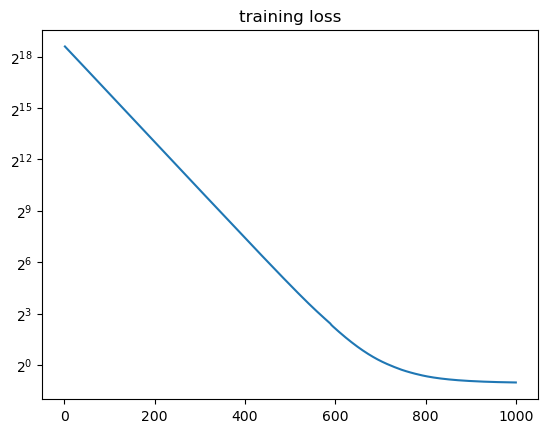

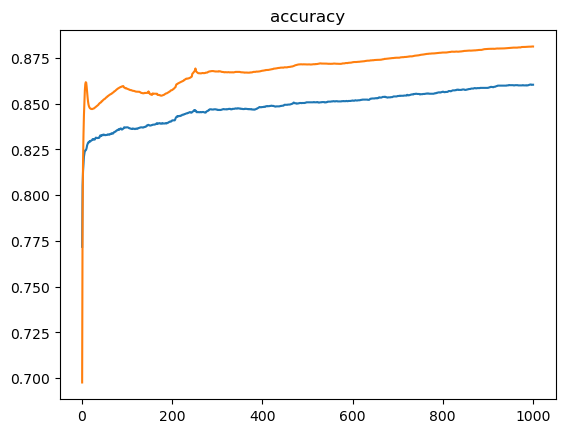

In [16]:
plt.figure()
plt.plot(np.arange(1,niter+1), loss2)
plt.yscale('log',base=2)
plt.title('training loss')

plt.figure()
plt.plot(np.arange(1,niter+1), accuracy_train)
plt.plot(np.arange(1,niter+1), accuracy_test)
plt.title('accuracy')